# Rope Positional Embedding

In [ ]:
from Dreamers.models.transformers.blocks import RopeEmbedding
T = 2047
D = 4
rope = RopeEmbedding(D, 2048)

In [ ]:
import torch

q = torch.zeros(2, 4, T, D)
k = torch.zeros(2, 4, T, D)

q[:, :, :, -4:] = torch.tensor([[1., 0., 0., 1.]])
k[:, :, :, -4:] = torch.tensor([[1., 0., 0., 1.]])
rq, rk = rope(q, k)

In [ ]:
q_odd, q_even = q[..., ::2], q[..., 1::2]
qJ = torch.stack([-q_even, q_odd], dim=-1).reshape_as(q)

q_rot = (q * rope.cos_emb[...,:T,:]) + (qJ * rope.sin_emb[...,:T,:])
plt.plot(q_rot[0,0,:,-4], q_rot[0,0,:,-3], 'x')
# plt.plot(q_rot[0,0,:512,-2], q_rot[0,0,:512,-1])
plt.xlim(-1, 1)
plt.ylim(-1, 1)

In [ ]:
from Dreamers.models.transformers.blocks import RopeEmbedding
from Dreamers.models.transformers.blocks import MultiHeadAttention

n_dim = 128
n_heads = 8
rope = RopeEmbedding(n_dim//n_heads, 2048)
attention = MultiHeadAttention(n_dim, n_heads, rope=rope)
x = torch.rand(32, 16, n_dim)
Y, A = attention(x, x, x)

In [ ]:
dim = 2
ndim = 5 # B, D1, D2, D3, D
range(1, dim), dim, range(dim+1, ndim)

# Creating the Masks

In [ ]:
import torch
import matplotlib.pyplot as plt
from Dreamers.models.transformers.utils import create_temporal_mask, create_encoder_spatial_mask, create_decoder_spatial_mask
mask = create_temporal_mask(5)
plt.imshow(mask.cpu().numpy(), cmap='gray')
plt.figure()
mask = create_encoder_spatial_mask(8, 1)
plt.imshow(mask.cpu().numpy(), cmap='gray')
plt.figure()
mask = create_decoder_spatial_mask(8, 1)
plt.imshow(mask.cpu().numpy(), cmap='gray')
plt.figure()

# Verifying the Attention Patterns

In [ ]:
from Dreamers.models.transformers.blocks import AxialAttention, Attention
n_dim = 128
n_heads = 8
T = 100
attention = Attention(n_dim, n_heads, n_kv_heads=n_heads, qk_norm=True,dropout_prob=0.0)
x1 = torch.rand(1, T, n_dim)
x2 = torch.rand(1, T, n_dim)
x2[:, 50:, :] = x1[:, 50:, :] # Change of the end tokens only and see if that changes the output of the earlier tokens
mask = create_temporal_mask(T, device=x1.device)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(mask.cpu().numpy(), cmap='gray')

In [ ]:

Y1 = attention(x1, x1, x1, mask=mask)
Y2 = attention(x2, x2, x2, mask=mask)
# The outputs after the change point should be identical
torch.allclose(Y1[:, 50:, :], Y2[:, 50:, :])

In [ ]:
import torch
import matplotlib.pyplot as plt
from Dreamers.models.transformers.blocks import AxialAttention, Attention
from Dreamers.models.transformers.utils import create_temporal_mask, create_encoder_spatial_mask, create_decoder_spatial_mask
n_dim = 128
n_heads = 8
T = 3 
N_patch = 16
N_latents = 4

temporal_mask = create_temporal_mask(T)
spatial_mask_enc = create_encoder_spatial_mask(N_patch, N_latents)
spatial_mask_dec = create_decoder_spatial_mask(N_patch, N_latents)

attention1 = Attention(n_dim, n_heads, n_kv_heads=n_heads, qk_norm=True,dropout_prob=0.0)
attention2 = Attention(n_dim, n_heads, n_kv_heads=n_heads, qk_norm=True,dropout_prob=0.0)
spatial_attention = AxialAttention(attention1)
temporal_attention = AxialAttention(attention2)
x = torch.rand(1, T, N_patch+N_latents, n_dim)

In [ ]:
x2 = x.clone()
x2[:, 1, -1, :] = 0 # Modalities can only attend to themselves and in the current timestep and the past --> chaning the latent should not affect the output of 

mask = spatial_mask_enc
Y1 = spatial_attention(x, x, x, dim=2, mask= mask)
Y1= temporal_attention(Y1, Y1, Y1, dim=1, mask=temporal_mask)
Y2 = spatial_attention(x2, x2, x2, dim=2,  mask=mask)
Y2= temporal_attention(Y2, Y2, Y2, dim=1, mask=temporal_mask)

diff = (Y1 - Y2).norm(dim=-1)
# plt.plot(diff[0,0,:].detach().cpu().numpy())
plt.imshow(diff[0].detach().cpu().numpy())

In [ ]:
x2 = x.clone()
x2[:, 1, 0, :] = 0 # latents can only attend to themselves and in the current timestep and the past --> chaning a spatial token should not affect output of latent tokens

mask = spatial_mask_dec
Y1 = spatial_attention(x, x, x, dim=2, mask= mask)
Y1= temporal_attention(Y1, Y1, Y1, dim=1, mask=temporal_mask)
Y2 = spatial_attention(x2, x2, x2, dim=2,  mask=mask)
Y2= temporal_attention(Y2, Y2, Y2, dim=1, mask=temporal_mask)

diff = (Y1 - Y2).norm(dim=-1)
# plt.plot(diff[0,0,:].detach().cpu().numpy())
plt.imshow(diff[0].detach().cpu().numpy())

# Checking Permutation Invariance with and without Rope

In [ ]:
from Dreamers.models.transformers.blocks import RopeEmbedding

n_dim = 128
n_heads = 8
T = 100
attention = Attention(n_dim, n_heads, n_kv_heads=n_heads, qk_norm=False,dropout_prob=0.0)


In [ ]:
attention = Attention(n_dim, n_heads, n_kv_heads=n_heads, qk_norm=False,dropout_prob=0.0)
x = torch.rand(1, T, n_dim)

# Define permutation (swap 0 and T-1)
perm = list(range(T))
perm[0], perm[-1] = perm[-1], perm[0]

# Apply permutation
x_perm = x[:, perm, :]

# Run attention
Y  = attention(x,      x,      x)
Yp = attention(x_perm, x_perm, x_perm)

# Undo permutation
inv_perm = [perm.index(i) for i in range(T)]
Yp_un = Yp[:, inv_perm, :]

print(torch.allclose(Y, Yp_un, atol=1e-6))

In [ ]:
rope = RopeEmbedding(n_dim//n_heads, 2048)
attention = Attention(n_dim, n_heads, n_kv_heads=n_heads, rope_embedder=rope, qk_norm=False,dropout_prob=0.0)
x = torch.rand(1, T, n_dim)
# Define permutation (swap 0 and T-1)
perm = list(range(T))
perm[0], perm[-1] = perm[-1], perm[0]
# Apply permutation
x_perm = x[:, perm, :]
# Run attention
Y  = attention(x,      x,      x)
Yp = attention(x_perm, x_perm, x_perm)
# Undo permutation
inv_perm = [perm.index(i) for i in range(T)]
Yp_un = Yp[:, inv_perm, :]
print(torch.allclose(Y, Yp_un, atol=1e-6))

# Tokenizer Encoder and Decoder

In [12]:
import torch
from Dreamers.models.transformers.model import CausalTokenizerEncoder, CausalTokenizerDecoder, CausalTokenizerConfig
cfg = CausalTokenizerConfig(
    num_modality_tokens=32,
    num_latent_tokens=32,
    max_context_lenghth=192,
    num_input_channels=128,
    model_dim=128,
    latent_dim=128,
    num_layers=8, # Number of BlockCausalLayers (Each block has 3 spatial and 1 temporal layer)
    n_heads=8,
    n_kv_heads=4,
    dropout_prob=0.0,
    qk_norm=True,
)
encoder = CausalTokenizerEncoder(cfg)
decoder = CausalTokenizerDecoder(cfg)

In [13]:
# get the number of model parameters
num_params = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
print(f"Number of encoder parameters (M): {num_params/1e6:.2f}M")

num_params = sum(p.numel() for p in decoder.parameters() if p.requires_grad)
print(f"Number of decoder parameters (M): {num_params/1e6:.2f}M")

Number of encoder parameters (M): 23.17M
Number of decoder parameters (M): 23.17M


In [14]:
x = torch.rand(1, 32, cfg.num_modality_tokens, cfg.num_input_channels) 
Y, _ = encoder(x)
x_recon = decoder(Y)
x_recon.shape

torch.Size([1, 32, 64, 128])

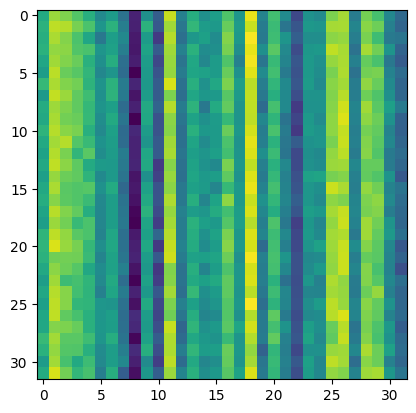

In [15]:
import matplotlib.pyplot as plt
plt.imshow(Y[0].mean(dim=-1).detach())

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
from model.tokenizer import CausalTokenizerDecoder, CausalTokenizerEncoder, CausalTokenizerConfig, TokensToImageHead, ImagePatchifier
from model.utils import TokenMasker

cfg = CausalTokenizerConfig(
    num_modality_tokens=256,
    num_latent_tokens=32,
    max_context_length=192,
    model_dim=128,
    latent_dim=128,
    enc_num_layers=8, # Number of BlockCausalLayers (Each block has 3 spatial and 1 temporal layer)
    dec_num_layers=2, # Number of BlockCausalLayers (Each block has 3 spatial and 1 temporal layer)
    n_heads=8,
    n_kv_heads=4,
    dropout_prob=0.0,
    qk_norm=True,
    patch_size = 14,
)
encoder = CausalTokenizerEncoder(cfg)
decoder = CausalTokenizerDecoder(cfg)
patchifier = ImagePatchifier(cfg.patch_size, cfg.model_dim)
image_head = TokensToImageHead(cfg.model_dim, (224, 224), 14)
masker = TokenMasker(cfg.model_dim, cfg.num_modality_tokens)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# ------------------------------------------------------------------------------
#   Building blocks: ResnetBlock2D + Upsample block (Stable Diffusion style)
# ------------------------------------------------------------------------------

class ResnetBlock2D(nn.Module):
    def __init__(self, channels, num_groups=8):
        super().__init__()
        self.norm1 = nn.GroupNorm(num_groups=num_groups, num_channels=channels)
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(num_groups=num_groups, num_channels=channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)

    def forward(self, x):
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)

        h = self.norm2(h)
        h = F.silu(h)
        h = self.conv2(h)
        return x + h

class Upsample2D(nn.Module):
    """
    Upsample ×2 using SD-style: Conv with PixelShuffle OR nearest+conv.
    PixelShuffle gives sharper output with fewer artifacts.
    """
    def __init__(self, channels, factor=2):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.pixelshuffle = nn.PixelShuffle(factor)

    def forward(self, x):
        return self.pixelshuffle(F.silu(self.conv(x)))

class TokensToImageHead(nn.Module):
    def __init__(
        self,
        model_dim,
        img_size,
        patch_size,
        hidden_dim_multiplier=1,
        num_res_blocks=4,
        out_channels=3,
    ):
        super().__init__()

        self.H, self.W = img_size
        self.patch_size = patch_size

        self.h_patches = self.H // patch_size
        self.w_patches = self.W // patch_size

        hidden_dim = model_dim * hidden_dim_multiplier

        # Token → spatial map
        self.proj = nn.Conv2d(model_dim, hidden_dim, kernel_size=1)

        # Residual refinement blocks
        self.resblocks = nn.Sequential(
            *[ResnetBlock2D(hidden_dim) for _ in range(num_res_blocks)]
        )

        # Upsample ×2 (H/p → H)
        self.upsample = Upsample2D(hidden_dim)

        # Post-upsampling refinement
        self.post_resblocks = nn.Sequential(
            *[ResnetBlock2D(hidden_dim // 4) for _ in range(num_res_blocks // 2)]
        )

        # Final projection to RGB
        self.final_conv = nn.Sequential(
            nn.GroupNorm(32, hidden_dim // 4),
            nn.SiLU(),
            nn.Conv2d(hidden_dim // 4, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x):
        """
        x: (B, T, D)
        """
        B, T, D = x.shape
        assert T == self.h_patches * self.w_patches, "Token count mismatch."

        # 1. Tokens → spatial feature map
        x = x.transpose(1, 2).reshape(B, D, self.h_patches, self.w_patches)
        # 2. Project into convolutional feature space
        x = self.proj(x)

        # 3. Residual refinement at low resolution
        x = self.resblocks(x) 
        # 4. Upsample to full image resolution
        x = self.upsample(x)

        # 5. Additional refinement at full resolution
        x = self.post_resblocks(x)

        # 6. Final RGB
        return self.final_conv(x)
    
image_head = TokensToImageHead(cfg.model_dim, (224, 224), 14)

In [2]:
B = 4
T = 3 
H, W = 224, 224
imgs = torch.ones(B, T, 3, H, W)
modality = patchifier(imgs)
modality = masker(modality)
latents, patch_embeddings = encoder(modality)
modality_tokens=decoder(latents)

In [3]:
imgs_recon = image_head(modality_tokens)
imgs_recon.shape

torch.Size([4, 3, 3, 224, 224])

In [6]:
masked = masker(modality)

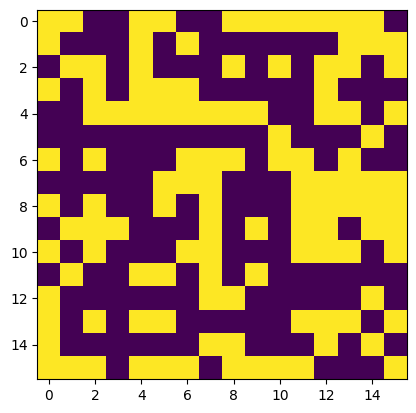

In [7]:
import matplotlib.pyplot as plt
mask_img = masked.sum(dim=-1).view(B, T, 16,16)[0]
plt.imshow(mask_img[2].detach())

## Attention Pattern Verification

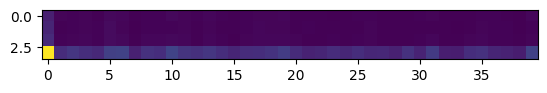

In [5]:
import matplotlib.pyplot as plt
x2 = x.clone()
x2[:, -1, 0, :] = 0 # Modalities can only attend to themselves and in the current timestep and the past --> chaning the latent should not affect the output of 

Y1_emb, Y1_patch = encoder(x)
Y2_emb, Y2_patch = encoder(x2)

Y1 = torch.cat([Y1_patch, Y1_emb], dim=2)
Y2 = torch.cat([Y2_patch, Y2_emb], dim=2)

diff = (Y1 - Y2).norm(dim=-1)
plt.imshow(diff[0].detach().cpu().numpy())

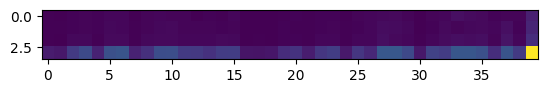

In [8]:
import matplotlib.pyplot as plt
x2 = x.clone()
x2[:, -1, -1, :] = 0 # Modalities can only attend to themselves and in the current timestep and the past --> chaning the latent should not affect the output of 

Y1 = decoder(x)
Y2 = decoder(x2)

diff = (Y1 - Y2).norm(dim=-1)
plt.imshow(diff[0].detach().cpu().numpy())